# Imports

In [313]:
import pandas as pd
import prim_utils as pu
import nltk
from nltk.corpus import stopwords
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/georgiaray_ic/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/georgiaray_ic/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/georgiaray_ic/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Loading the Original Data

In [314]:
df = pd.read_csv("../combined_ar6_data.csv")

In [315]:
df_pivot = (
    df
    .query("year in [2030, 2050]")  
    .pivot_table(index=["model", "scenario"], 
                 columns=["variable", "year"], 
                 values="value")
)


# Finding Original Stats about Variable Coverage

In [316]:
variable_table = pu.variable_coverage_table(df_pivot, years=[2030, 2050])

In [317]:
variable_table

,Variable,Coverage (Scenarios)
0,OM Cost|Storage|Thermal Energy Storage|Househo...,1
1,Final Energy|Industry|Chemicals|Liquids|Hydrog...,1
2,Final Energy|Industry|Chemicals|Gases|Hydrogen...,1
3,Final Energy|Industry|Steel|Gases|Hydrogen syn...,1
4,Final Energy|Industry|Steel|Liquids|Hydrogen s...,1
...,...,...
1647,Primary Energy|Coal,2504
1648,Primary Energy,2509
1649,Primary Energy|Gas,2512
1650,Secondary Energy|Electricity,2527


# Using NLP to separate into sector categories

## Rule based keyword matching

In [318]:
sectors = ['Electrcity', 'Transport', 'Industry', 'Buildings', 'Agriculture']
variables = variable_table.Variable.unique()

In [319]:
stop_words = set(stopwords.words('english'))

In [320]:
sector_terms = [s.lower() for s in sectors] 

In [321]:
sector_keywords = {
    "electricity": ["electricity", "power", "grid"],
    "transport": ["transport", "vehicle", "freight", "passenger"],
    "industry": ["industry", "cement", "steel", "manufacturing"],
    "buildings": ["building", "residential", "commercial"],
    "agriculture": ["agriculture", "land", "livestock", "crop", "afolu"]
}

In [322]:
sectors = []
for _, variable in variable_table.iterrows():
    sector = pu.assign_sector(variable["Variable"], sector_keywords)
    sectors.append(sector)

variable_table["sector"] = sectors

______

# Somehow make sure these are properly aligned to the sectors

____

# Select Variables to Reduce Correlation and Increase Coverage

In [323]:
df_flat = df_pivot.copy()
df_flat.columns = [f"{var}:{year}" for var, year in df_flat.columns]
df_flat = df_flat.reset_index() 

In [324]:
# Separate into five new dataframes based on the sector
electricity_df = variable_table[variable_table["sector"] == "Electricity"]
transport_df = variable_table[variable_table["sector"] == "Transport"]
industry_df = variable_table[variable_table["sector"] == "Industry"]
buildings_df = variable_table[variable_table["sector"] == "Buildings"]
agriculture_df = variable_table[variable_table["sector"] == "Agriculture"]

In [325]:
electricity_df

,Variable,Coverage (Scenarios),sector
6,Cumulative Capacity|Electricity|Ocean,1,Electricity
103,Discount rate|Electricity,5,Electricity
115,Capacity| Electricity|Solar|PV|Rooftop PV,7,Electricity
116,Capacity|Electricity|Storage|Battery Capacity,7,Electricity
117,Capacity|Electricity|Storage|Battery Capacity|...,7,Electricity
...,...,...,...
1643,Secondary Energy|Electricity|Solar,2472,Electricity
1644,Secondary Energy|Electricity|Wind,2477,Electricity
1645,Secondary Energy|Electricity|Nuclear,2486,Electricity
1650,Secondary Energy|Electricity,2527,Electricity


In [326]:
# Extract variables with at least 300 scenarios of coverage for each sector
min_coverage = 300
sectoral_by_category = {}

sector_dfs = {
    "Electricity": electricity_df,
    "Transport": transport_df,
    "Industry": industry_df,
    "Buildings": buildings_df,
    "Agriculture": agriculture_df
}

for sector, df in sector_dfs.items():
    filtered_vars = (
        df[df["Coverage (Scenarios)"] >= min_coverage]
        .sort_values("Coverage (Scenarios)", ascending=False)["Variable"]
        .tolist()
    )
    sectoral_by_category[sector] = filtered_vars
    print(f"{sector}: {len(filtered_vars)} variables retained (≥ {min_coverage} scenarios)")


Electricity: 261 variables retained (≥ 300 scenarios)
Transport: 22 variables retained (≥ 300 scenarios)
Industry: 21 variables retained (≥ 300 scenarios)
Buildings: 42 variables retained (≥ 300 scenarios)
Agriculture: 42 variables retained (≥ 300 scenarios)


In [327]:
#computing the current correlation matrix to identify the most correlated variables
corr_matrix = df_pivot.corr().abs()

In [328]:
#run a sampling to identify best variables 
results = pu.select_variable_combinations(df_pivot, sectoral_by_category, corr_threshold = 0.8, completeness_threshold= 0.9, min_vars = 2, num_samples=5000)

Combo 1: 159 scenarios | Max corr: 0.80
Variables: ['Capacity Additions|Electricity|Biomass|w|CCS', 'Capacity|Electricity|Solar|PV', 'Final Energy|Transportation|Freight|Hydrogen', 'Energy Service|Transportation|Passenger', 'Emissions|NH3|Energy|Demand|Industry', 'Carbon Sequestration|CCS|Fossil|Energy|Demand|Industry', 'Emissions|CO2|Energy|Demand|Residential and Commercial|Residential', 'Emissions|NH3|Energy|Demand|Residential and Commercial', 'Emissions|OC|AFOLU', 'Land Cover|Cropland|Irrigated', 'OM Cost|Fixed|Electricity|Coal|w|CCS', 'Capacity Additions|Electricity|Biomass|w o CCS', 'Capacity Additions|Electricity|Non-Biomass Renewables', 'Final Energy|Transportation|Freight|Liquids|Bioenergy', 'Final Energy|Transportation|Passenger|Liquids|Bioenergy', 'Final Energy|Transportation|Passenger|Electricity', 'Final Energy|Industry|Heat', 'Final Energy|Industry|Solids', 'Final Energy|Industry|Liquids', 'Emissions|CO|Energy|Demand|Residential and Commercial', 'Price|Final Energy|Residen

In [329]:
results[0]

{'variables': ['Capacity Additions|Electricity|Biomass|w|CCS',
  'Capacity|Electricity|Solar|PV',
  'Final Energy|Transportation|Freight|Hydrogen',
  'Energy Service|Transportation|Passenger',
  'Emissions|NH3|Energy|Demand|Industry',
  'Carbon Sequestration|CCS|Fossil|Energy|Demand|Industry',
  'Emissions|CO2|Energy|Demand|Residential and Commercial|Residential',
  'Emissions|NH3|Energy|Demand|Residential and Commercial',
  'Emissions|OC|AFOLU',
  'Land Cover|Cropland|Irrigated',
  'OM Cost|Fixed|Electricity|Coal|w|CCS',
  'Capacity Additions|Electricity|Biomass|w o CCS',
  'Capacity Additions|Electricity|Non-Biomass Renewables',
  'Final Energy|Transportation|Freight|Liquids|Bioenergy',
  'Final Energy|Transportation|Passenger|Liquids|Bioenergy',
  'Final Energy|Transportation|Passenger|Electricity',
  'Final Energy|Industry|Heat',
  'Final Energy|Industry|Solids',
  'Final Energy|Industry|Liquids',
  'Emissions|CO|Energy|Demand|Residential and Commercial',
  'Price|Final Energy|Resi

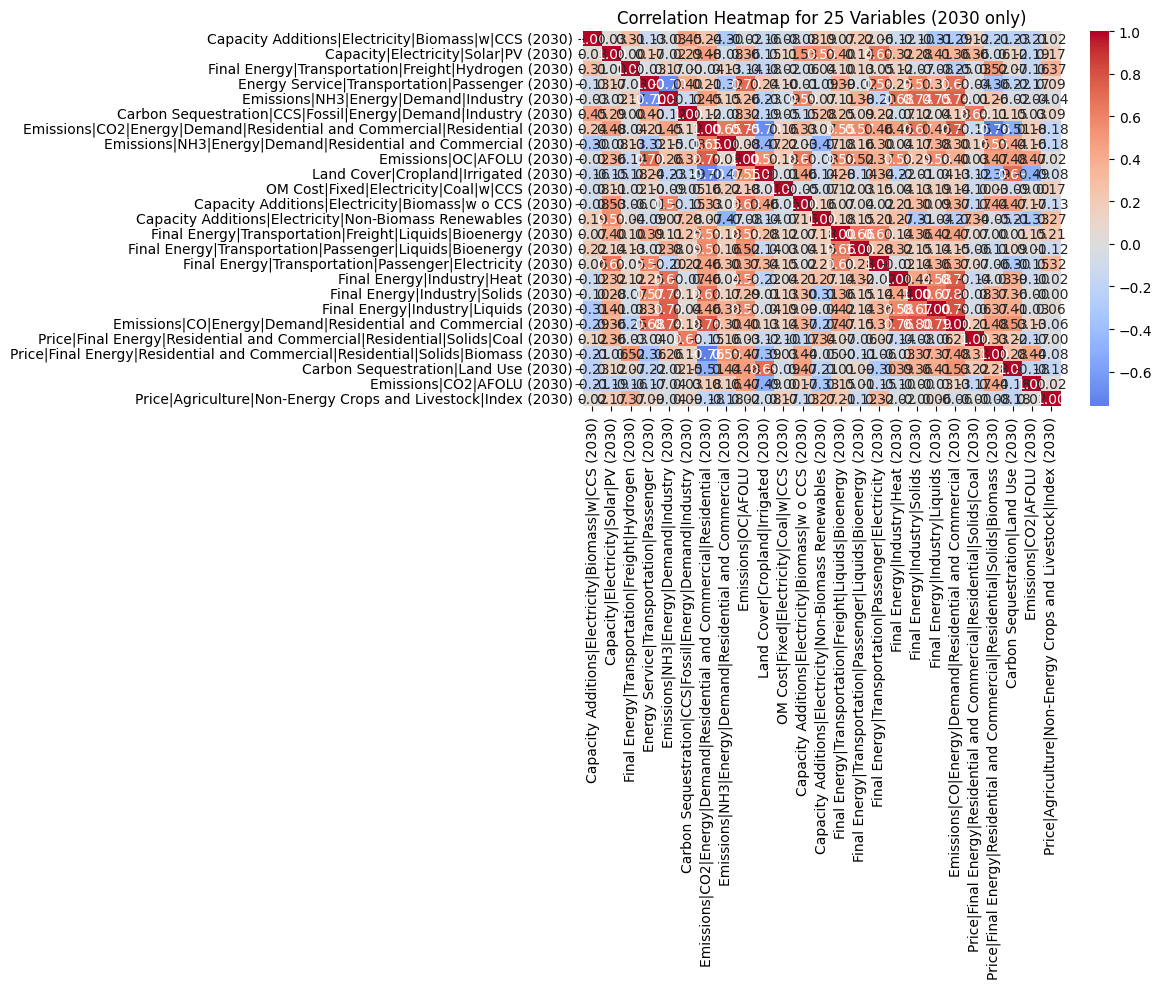


Top 10 Most Correlated Pairs:
Emissions|CO|Energy|Demand|Residential and Commercial (2030) & Final Energy|Industry|Solids (2030): 0.80
Final Energy|Industry|Solids (2030) & Emissions|CO|Energy|Demand|Residential and Commercial (2030): 0.80
Emissions|CO|Energy|Demand|Residential and Commercial (2030) & Final Energy|Industry|Liquids (2030): 0.79
Final Energy|Industry|Liquids (2030) & Emissions|CO|Energy|Demand|Residential and Commercial (2030): 0.79
Price|Final Energy|Residential and Commercial|Residential|Solids|Biomass (2030) & Emissions|CO2|Energy|Demand|Residential and Commercial|Residential (2030): 0.76
Emissions|CO2|Energy|Demand|Residential and Commercial|Residential (2030) & Price|Final Energy|Residential and Commercial|Residential|Solids|Biomass (2030): 0.76
Emissions|CO|Energy|Demand|Residential and Commercial (2030) & Emissions|CO2|Energy|Demand|Residential and Commercial|Residential (2030): 0.76
Emissions|CO2|Energy|Demand|Residential and Commercial|Residential (2030) & Emis

In [330]:
top_10, filtered = pu.make_heat_map(df_pivot, results[0]['variables'], threshold=0.8)


In [ ]:
#save the results 
import os
output_dir = "output"
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, "selected_variables_X.csv")
pu.save_filtered_scenarios(df_pivot, results[2]['variables'], save_path = output_file)

ValueError: No valid variable-year combinations found in df_pivot.

**Concern: Allowing for any variables that are NANs means I might just be getting the most consistent results in those runs where there are a lot of NANs for certain variables and that means they are less predictive. This doesn't mean they are less predictive sectors but maybe fewer variables across scenarios**

____

## Getting Electricity and Industry Variables

**NOTE TO SELF: The correlation for this part could be done more effectively**

In [359]:
# Exclude electricity df variables where coverage is less than 500 
industry_df_small = industry_df[industry_df["Coverage (Scenarios)"] >= 20]

In [360]:
industry_df_small

,Variable,Coverage (Scenarios),sector
307,Carbon Intensity|Production|Steel,21,Industry
309,Final Energy|Industry|Gases|Fossil,22,Industry
318,Carbon Intensity|Production|Cement|Industrial ...,24,Industry
364,Expenditure|household|Industry,31,Industry
371,Employment|Industry|Manufacturing,33,Industry
...,...,...,...
1560,Final Energy|Industry|Liquids,1811,Industry
1561,Final Energy|Industry|Electricity,1813,Industry
1563,Final Energy|Industry|Gases,1814,Industry
1610,Emissions|CO2|Energy|Demand|Industry,2175,Industry


In [361]:
# Further exclude those variables which have a greater than 0.8 correlation with any other variable; keep the one with the highest coverage

industry_vars = industry_df_small["Variable"].tolist()
industry_vars = [v for v in industry_vars if v in corr_matrix.index and v in corr_matrix.columns]
ind_corr_matrix = corr_matrix.loc[industry_vars, industry_vars]

In [362]:
# look through the correlation matrix and find pairs of variables with a correlation greater than 0.8
ind_corr_array = ind_corr_matrix.values
var_indices = {v: i for i, v in enumerate(ind_corr_matrix.index)}
correlated_pairs = []
for i in range(len(industry_vars)):
    for j in range(i + 1, len(industry_vars)):
        if ind_corr_array[i, j] > 0.9:
            correlated_pairs.append((industry_vars[i], industry_vars[j]))

# Keep only the variable with higher coverage in each correlated pair
selected_vars = {}
dropped_vars = set()

for var1, var2 in correlated_pairs:
    if var1 in dropped_vars or var2 in dropped_vars:
        continue

    coverage1 = industry_df.loc[industry_df["Variable"] == var1, "Coverage (Scenarios)"].values[0]
    coverage2 = industry_df.loc[industry_df["Variable"] == var2, "Coverage (Scenarios)"].values[0]

    if coverage1 >= coverage2:
        selected_vars[var1] = coverage1
        dropped_vars.add(var2)
    else:
        selected_vars[var2] = coverage2
        dropped_vars.add(var1)

# Final list = not dropped
final_industry_vars = [v for v in industry_vars if v not in dropped_vars]

In [370]:
# Step 1: Filter df_pivot to just those variables and years
df_industry_wide = df_pivot.loc[:, df_pivot.columns.get_level_values(0).isin(final_industry_vars)]

# Step 2: Flatten column names from MultiIndex to "Variable (Year)" format
df_industry_wide.columns = [f"{var} ({year})" for var, year in df_industry_wide.columns]

# Step 3: Reset index to bring model and scenario into columns
df_industry_wide = df_industry_wide.reset_index()

In [371]:
df_industry_wide

,model,scenario,Emissions|CO2|Energy|Demand|Industry|Steel (2030),Emissions|CO2|Energy|Demand|Industry|Steel (2050),Emissions|Sulfur|Energy|Demand|Industry (2030),Emissions|Sulfur|Energy|Demand|Industry (2050),Final Energy (excl. feedstocks)|Industry|Gases (2030),Final Energy (excl. feedstocks)|Industry|Gases (2050),Final Energy (excl. feedstocks)|Industry|Gases|Fossil (2030),Final Energy (excl. feedstocks)|Industry|Gases|Fossil (2050),...,Final Energy|Industry|Pulp and Paper|Hydrogen (2030),Final Energy|Industry|Pulp and Paper|Hydrogen (2050),Final Energy|Industry|Pulp and Paper|Solids|Bioenergy (2030),Final Energy|Industry|Pulp and Paper|Solids|Bioenergy (2050),Final Energy|Industry|Solids|Biomass (2030),Final Energy|Industry|Solids|Biomass (2050),Final Energy|Industry|Solids|Coal (2030),Final Energy|Industry|Solids|Coal (2050),Final Energy|Industry|Steel|Solids|Fossil (2030),Final Energy|Industry|Steel|Solids|Fossil (2050)
0,7see Mk5-20 GB,JPC to 0.8 of asymptote,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,7see Mk5-20 GB,JPC to asymp. with high population projection,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7see Mk5-20 GB,JPC to asymp. with low population projection,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,7see Mk5-20 GB,JPC to asymptote,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,7see Mk5-30 GB,GB 5CB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3236,eTIMES-EU 1.0,NEUTR_I85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3237,eTIMES-EU 1.0,NEUTR_J45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3238,eTIMES-EU 1.0,NEUTR_J85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3239,eTIMES-EU 1.0,NEUTR_L45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [381]:
data_columns = df_industry_wide.columns.difference(['model', 'scenario'])
required_non_null = int(0.8 * len(data_columns))

df_industry_wide_filtered = df_industry_wide[df_industry_wide[data_columns].notnull().sum(axis=1) >= required_non_null]

print(f"Filtered to {len(df_industry_wide_filtered)} scenarios with ≥80% coverage")

Filtered to 39 scenarios with ≥80% coverage


In [382]:
df_industry_wide_filtered

,model,scenario,Emissions|CO2|Energy|Demand|Industry|Steel (2030),Emissions|CO2|Energy|Demand|Industry|Steel (2050),Emissions|Sulfur|Energy|Demand|Industry (2030),Emissions|Sulfur|Energy|Demand|Industry (2050),Final Energy (excl. feedstocks)|Industry|Gases (2030),Final Energy (excl. feedstocks)|Industry|Gases (2050),Final Energy (excl. feedstocks)|Industry|Gases|Fossil (2030),Final Energy (excl. feedstocks)|Industry|Gases|Fossil (2050),...,Final Energy|Industry|Pulp and Paper|Hydrogen (2030),Final Energy|Industry|Pulp and Paper|Hydrogen (2050),Final Energy|Industry|Pulp and Paper|Solids|Bioenergy (2030),Final Energy|Industry|Pulp and Paper|Solids|Bioenergy (2050),Final Energy|Industry|Solids|Biomass (2030),Final Energy|Industry|Solids|Biomass (2050),Final Energy|Industry|Solids|Coal (2030),Final Energy|Industry|Solids|Coal (2050),Final Energy|Industry|Steel|Solids|Fossil (2030),Final Energy|Industry|Steel|Solids|Fossil (2050)
1735,IMAGE 3.2,SSP1-baseline,241.512006,251.175376,4.205064,2.997677,4.276677,6.862639,4.276677,6.862639,...,0.000000e+00,0.000000e+00,0.279432,0.348100,1.605651,2.851209,6.043920,3.651019,1.774017,1.731983
1736,IMAGE 3.2,SSP1_SPA1_19I_D,174.564481,53.448198,3.476688,1.855524,3.481025,3.874623,3.481025,3.874623,...,0.000000e+00,0.000000e+00,0.327423,0.641502,1.633997,3.463564,4.860509,2.294910,1.490150,1.425117
1737,IMAGE 3.2,SSP1_SPA1_19I_D_LB,133.073669,27.667264,3.167922,1.603398,2.947451,4.829454,2.947451,4.829454,...,2.842908e-11,0.000000e+00,0.427562,0.612159,2.171023,2.738089,4.161584,1.240493,1.166850,0.718983
1738,IMAGE 3.2,SSP1_SPA1_19I_LI,174.799862,44.119313,3.415741,1.551528,3.327546,3.369552,3.327546,3.369552,...,0.000000e+00,0.000000e+00,0.308053,0.397012,1.665133,3.151022,4.782316,1.759661,1.487545,1.055548
1739,IMAGE 3.2,SSP1_SPA1_19I_LIRE,171.583996,29.244835,3.362844,1.126012,3.060868,2.603929,3.060868,2.603929,...,0.000000e+00,0.000000e+00,0.299834,0.338105,1.648408,2.430060,4.767631,1.119924,1.444506,0.362433
1740,IMAGE 3.2,SSP1_SPA1_19I_LIRE_LB,134.075179,11.279260,3.109293,0.993705,2.732672,2.617942,2.732672,2.617942,...,3.381919e-11,0.000000e+00,0.355325,0.370034,1.886868,2.491879,4.200088,0.935429,1.147984,0.221527
1741,IMAGE 3.2,SSP1_SPA1_19I_RE,168.940626,28.407958,3.339593,1.307916,2.965511,2.465493,2.965511,2.465493,...,0.000000e+00,0.000000e+00,0.334189,0.649140,1.769224,3.526872,4.729165,1.052052,1.458356,0.390180
1742,IMAGE 3.2,SSP1_SPA1_19I_RE_LB,134.630979,11.450373,3.107270,1.153899,2.734291,3.002477,2.734291,3.002477,...,3.297216e-11,0.000000e+00,0.412053,0.607915,1.985600,2.712361,4.172226,0.966852,1.152689,0.227417
1743,IMAGE 3.2,SSP1_SPA1_26I_D,193.149259,89.571598,3.624178,2.119841,3.544239,4.147436,3.544239,4.147436,...,0.000000e+00,0.000000e+00,0.305647,0.536440,1.751302,3.885724,5.045780,2.561720,1.544226,1.512873
1744,IMAGE 3.2,SSP1_SPA1_26I_LI,214.701866,88.477463,3.782825,1.883295,3.883126,4.109290,3.883126,4.109290,...,0.000000e+00,0.000000e+00,0.281041,0.331905,1.774267,3.386619,5.239541,2.076414,1.667426,1.100573


In [383]:
#save the final electricity variables
output_file = os.path.join(output_dir, "selected_industry_variables.csv")
df_industry_wide_filtered.to_csv(output_file, index=False)